# Определение перспективного тарифа для телеком-компании

Компания *"Мегалайн"* является федеральным оператором сотовой связи. Клиентам предлагают два тарифных плана: *"Смарт"* и *"Ультра"*. Коммерческий департамент хочет понять, какой тариф приносит больше денег, чтобы скорректировать рекламный бюджет.

Необходимо на небольшой выборке сделать предварительный анализ тарифов. В распоряжении 500 пользователей *"Мегалайна"*: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Необходимо проанализировать поведение клиентов и сделать вывод - какой тариф лучше.

**Описание тарифов**

*Тариф "Смарт"*
1. Ежемесячная плата: 500 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговорва: 3 рубля
   - сообщение: 3 рубля
   - 1Гб интернет трафика: 200 рублей

*Тариф "Ультра"*
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1Гб интернет-трафика: 150 рублей


**Примечание**

*"Мегалайн"* всегда округляет секунды до минут, а мегабайты - до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в большую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет не следующий месяц не переносятся.я.

## Изучение данных из файлов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import datetime as dt
import math

In [2]:
calls = pd.read_csv("calls.csv")
internet = pd.read_csv("internet.csv")
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]
messages = pd.read_csv("messages.csv")
tariffs = pd.read_csv("tariffs.csv")
users = pd.read_csv("users.csv")

In [3]:
print(calls.info())
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
print(messages.info())
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
print(tariffs.info())
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
calls.duplicated().sum() + internet.duplicated().sum() + messages.duplicated().sum() + tariffs.duplicated().sum() + users.duplicated().sum()

0

### Вывод

1. `calls`
   - `call_date` перевести в дату
   - `duration` принимает нулевые значения, когда звонок пропущен
   - `duration` необходимо округлить в большую сторону
2. `internet`
   - `session_date` перевести в дату
3. `messages`
   - `message_date` перевести в дату
4. `users`
   - `churn_date` перевести в дату
   - `churn_date` принимает *NaN*, если на момент выгрузки данных у пользователя действовал тариф
   - `reg_date` перевести в дату
5. `tariffs` ничего менять не надо
6. Дубликатов нет

## Преодобработка данных

Обработаем столбцы на основании *1.1. Вывод*

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = calls['duration'].apply(lambda x: math.ceil(x))

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объём израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Добавим столбцы с номером месяца в `calls`, `internet` и `messages`

In [10]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

Создадим дополнительный датафрейм со статистикой по каждому пользователю

In [11]:
stats = pd.DataFrame(columns=['user_id', 'month', 'tariff', 'calls_count', 'minutes', 'mess_count', 'gb'])
for i in range(1000, 1500):
    for j in range(1, 13):
        stats.loc[len(stats.index)] = [i, j, 
                                       users[users['user_id'] == i]['tariff'][i-1000],
                                       calls[(calls['month'] == j) & (calls['user_id'] == i)]['id'].count(),
                                       calls[(calls['month'] == j) & (calls['user_id'] == i)]['duration'].sum(), 
                                       messages[(messages['month'] == j) & (messages['user_id'] == i)]['id'].count(), 
                                       math.ceil(internet[(internet['month'] == j) & (internet['user_id'] == i)]['mb_used'].sum() / 1024)]

Функция для подсчёт месячной выручки с каждого пользователя

In [12]:
def revenue(line):
    if (line['calls_count'] == 0 and line['minutes'] == 0 and line['mess_count'] == 0 and line['gb'] == 0):
        return 0
    else:
        rev = 0
        tariff = line['tariff']
        
        # стоимость тарифа
        rev += int(tariffs[tariffs['tariff_name'] == tariff]['rub_monthly_fee'])
        
        # стоимость дополнительных минут
        temp = int(line['minutes'] - tariffs[tariffs['tariff_name'] == tariff]['minutes_included'])
        rev += (temp * int(tariffs[tariffs['tariff_name'] == tariff]['rub_per_minute'])) if temp > 0 else 0
        
        # стоимость дополнительнох смс
        temp = int(line['mess_count'] - tariffs[tariffs['tariff_name'] == tariff]['messages_included'])
        rev += (temp * int(tariffs[tariffs['tariff_name'] == tariff]['rub_per_message'])) if temp > 0 else 0
        
        #стоимость дополнительного трафика
        temp = int(line['gb'] - tariffs[tariffs['tariff_name'] == tariff]['mb_per_month_included'] / 1024)
        rev += (temp * int(tariffs[tariffs['tariff_name'] == tariff]['rub_per_gb'])) if temp > 0 else 0
        return rev

Добавим столбец месячной выручки с каждого пользователя

In [13]:
stats['revenue'] = stats.apply(lambda x: revenue(x), axis=1) 

In [14]:
stats.head()

,user_id,month,tariff,calls_count,minutes,mess_count,gb,revenue
0,1000,1,ultra,0,0,0,0,0
1,1000,2,ultra,0,0,0,0,0
2,1000,3,ultra,0,0,0,0,0
3,1000,4,ultra,0,0,0,0,0
4,1000,5,ultra,22,159,22,3,1950


Проверим, есть ли пользователи, которые в течении месяца не использовали услуги связи, но не отменяли тариф

In [15]:
list_users_12 = []
for i in range(1, stats.shape[0] - 1):
    if ((stats.loc[i, 'calls_count'] == 0) and 
        (stats.loc[i, 'minutes'] == 0) and 
        (stats.loc[i, 'mess_count'] == 0) and 
        (stats.loc[i, 'gb'] == 0) and
        (stats.loc[i-1, 'calls_count'] != 0) and 
        (stats.loc[i-1, 'minutes'] != 0) and 
        (stats.loc[i-1, 'mess_count'] != 0) and 
        (stats.loc[i-1, 'gb'] != 0) and
        (stats.loc[i, 'month'] > stats.loc[i-1, 'month']) and
        (((stats.loc[i, 'month'] < stats.loc[i+1, 'month']) and 
        (stats.loc[i+1, 'calls_count'] != 0) and 
        (stats.loc[i+1, 'minutes'] != 0) and 
        (stats.loc[i+1, 'mess_count'] != 0) and 
        (stats.loc[i+1, 'gb'] != 0)) or (stats.loc[i, 'month'] == 12))):
        list_users_12.append(stats.loc[i, 'user_id'])

In [16]:
list_users_12

[1034, 1161, 1232, 1271, 1293, 1353, 1355]

In [18]:
users[users['user_id'].isin(list_users_12)][['user_id', 'churn_date']]

,user_id,churn_date
34,1034,2018-11-21
161,1161,2018-11-07
232,1232,2018-11-30
271,1271,2018-11-13
293,1293,2018-11-22
353,1353,2018-11-26
355,1355,2018-11-27


Таким образом мы убедились, что взяли плату за неактивный месяц с пользователя, который не отменял тариф

Отбросим все строки, в которых указан нулевой доход

In [19]:
stats = stats.loc[stats['revenue'] != 0].reset_index(drop=True)

In [20]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      3214 non-null   object
 1   month        3214 non-null   object
 2   tariff       3214 non-null   object
 3   calls_count  3214 non-null   object
 4   minutes      3214 non-null   object
 5   mess_count   3214 non-null   object
 6   gb           3214 non-null   object
 7   revenue      3214 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 201.0+ KB


Присвоим правильные типы столбцов

In [21]:
stats['user_id'] = stats['user_id'].astype(int)
stats['month'] = stats['month'].astype(int)
stats['calls_count'] = stats['calls_count'].astype(int)
stats['minutes'] = stats['minutes'].astype(int)
stats['mess_count'] = stats['mess_count'].astype(int)
stats['gb'] = stats['gb'].astype(int)

## Анализ данных

Для минут разговора, количества сообщений и объёма интернет-трафика по месяцам необходимо:
- посчитать среднее количество;
- стандартное отклонение;
- построить гистограммы;
- описать распределение.

Посмотрим на метод `.describe()` для всей выборки

In [22]:
stats[['minutes', 'mess_count', 'gb']].describe()

,minutes,mess_count,gb
count,3214.000000,3214.000000,3214.000000
mean,451.244866,38.281269,17.299004
std,241.909978,36.148326,7.400584
min,0.000000,0.000000,0.000000
25%,282.000000,9.000000,13.000000
50%,443.000000,30.000000,17.000000
75%,589.000000,57.000000,21.000000
max,1673.000000,224.000000,49.000000


Посмотрим `.describe()` для пользователей с тарифом *"Сматр"*

In [23]:
stats[stats['tariff'] == 'smart'][['minutes', 'mess_count', 'gb', 'revenue']].describe()

,minutes,mess_count,gb,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.328847,1289.973531
std,190.313730,28.227876,5.747061,818.404367
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,10.000000,13.000000,550.000000
50%,422.000000,28.000000,17.000000,1023.000000
75%,545.000000,51.000000,20.000000,1750.000000
max,1435.000000,143.000000,38.000000,6770.000000


Посмотрим `.describe()` для пользователей с тарифом *"Ультра"*

In [24]:
stats[stats['tariff'] == 'ultra'][['minutes', 'mess_count', 'gb', 'revenue']].describe()

,minutes,mess_count,gb,revenue
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.494416,2070.152284
std,317.606098,47.804457,9.853511,376.187114
min,0.000000,0.000000,0.000000,1950.000000
25%,284.000000,6.000000,12.000000,1950.000000
50%,518.000000,38.000000,19.000000,1950.000000
75%,752.000000,79.000000,27.000000,1950.000000
max,1673.000000,224.000000,49.000000,4800.000000


Изучим средние значения из метода `.descrive()`:
- среднее количество минут разговора в месяц у всех пользователей составило 451 минуту
  - для пользователей с тарифом *"Смарт"* - 417 минут
  - для пользователей с тафифом *"Ультра"* - 526 минут
- среднее количество сообщений в месяц у всех пользователей - 38 сообщений
  - для *"Смарт"* - 33 сообщений
  - для *"Ультра"* - 49 сообщений
- средний объём потребляемого интернет-трафика у всех пользователей - 17.3 Гб
  - для *"Смарт"* - 16.3 Гб
  - для *"Ультра"* - 19.5 Гб

Ещё посмотрим на средний доход от пользователей из разных тарифов:
- для пользователей тарифа *"Смарт"* - 1290 рублей
- для пользователей тарифа *"Ультра"* - 2070 рублей

Из этих данных можно увидеть, что в среднем пользователи обоих тарифом укладываются в предоставляемый пакет минут и сообщений. А пользователи тарифа *"Смарт"* не укладываются в предоставленный пакет интернет-трафика, в отличаи от пользователей тарифа *"Ультра"*. В среднем пользователи тарифа *"Смарт"* в месяц платят **в 2 раза больше** за услуги связи, чем стоимость месячного тарифа. Тогда как пользователи тарифа *"Ультра"* в среднем платят всего на 20 рублей больше.

Изучим медианные значения из метода `.describe()`:
- медианное значение количества минут разговора в месяц у всех пользователей - 443 минут
  - для *"Смарт"* - 422 минут
  - для *"Ультра"* - 518 минут
- медианное значение количества сообщений у всех пользователей - 30 сообщений
  - для *"Смарт"* - 28 сообщений
  - для *"Ультра"* - 38 сообщений
- медианное значение объёма потребляемого интернет-трафика у всех пользователей - 17 Гб
  - для *"Смарт"* - 17 Гб
  - для *"Ультра"* - 19 Гб
 
Медианные значения доходов по каждому тарифу:
- для *"Смарт"* - 1023 рублей
- для *"Ультра"* - 1950 рублей

Из данных о медианных значений можно увидеть, что большинство пользователей не выходят за рамки предоставленного пакета минут разговора и количества сообщений. Большинство пользователей тарифа *"Смарт"* используют на 2 Гб больше предоставленного объёма интернет-трафика, а пользователи *"Ультра"* укладываются в предоставленный пакет. Большинство пользователей тарифа *"Смарт"* в месяц платят **почти в 2 раза больше**, чем стоимость месячного пакета услуг. Пользователи тарифа *"Ультра"* в большинстве платят фиксированную сумму, но если посмотреть на строку `75%`, то мы увидем, что второй третий квартиль тоже равен 1950.

Осмотрим стандратное отклонение из метода `.describe()`:
- стандартное отклонение количества минут разговора в месяц у всех пользователей - 241.9
  - для *"Смарт"* - 190.3
  - для *"Ультра"* - 317.6
- стандартное отклонение количества сообщений у всех пользователей - 36.1
  - для *"Смарт"* - 28.2
  - для *"Ультра"* - 47.8
- стандартное отклонение объёма потребляемого интернет-трафика у всех пользователей - 7.4
  - для *"Смарт"* - 5.7
  - для *"Ультра"* - 9.8
 
Стандартное отклонение доходов по каждому тарифу:
- для *"Смарт"* - 818.4
- для *"Ультра"* - 376.2

Из данных о стандартном отклонении можно сделать вывод, что пользователи тарифа *"Смарт"* по использованию пакета связи отличаются между собой не так сильно, как пользователи тарифа *"Ультра"*. Можно предположить, что это связано с тем, что пользователи тарифа *"Смарт"* стараются экономить, чтобы уложиться в пакет связи, тогда как у пользователей тарифа *"Ультра"* пакет намного больше, большее 75% пользователей этого тарифа даже не используют дополнительный пакет услуг, значит и экономят они не так сильно, ведь в этом нет необходимости. Частое прибегание к дополнительному пакету услуг у пользователей тарифа *"Смарт"* так же отражено в среднем отклонении дохода от пользователей этого тарифа, оно в 2 раза больше, чем стандратное отклонение дохода от пользователей тарифа "*Ультра"*.

<AxesSubplot:title={'center':'revenue'}, xlabel='tariff'>

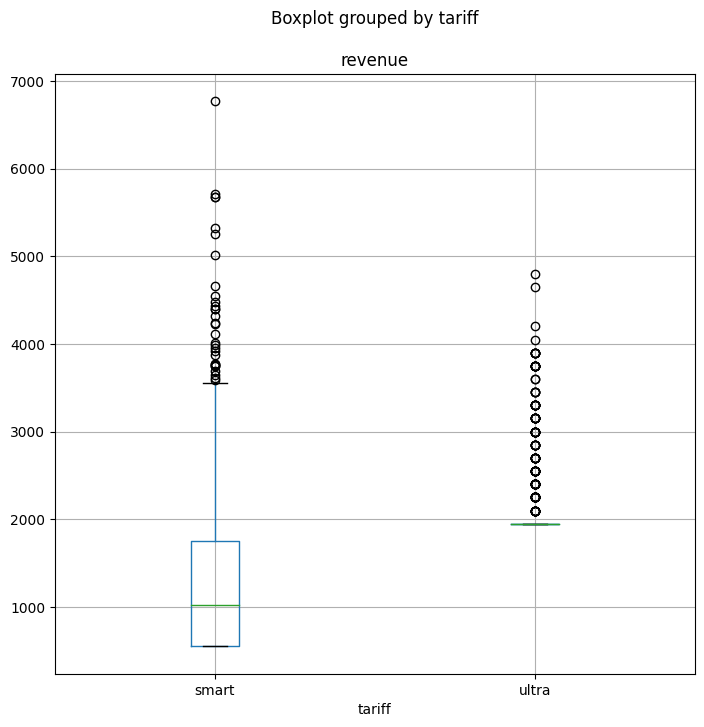

In [25]:
stats.boxplot('revenue', by='tariff', figsize=(8, 8))

На графике рассеивания видно, что доход выше 3500 у тарифа *"Смарт"* считается выбросами, тогда как у тарифа *"Ультра"* любое значение, кроме 1950, считается выбросом.

Построим гистограммы количетва минут разговоров, количества сообщений и объёма интернет-трафика потребляемых каждым пользователем.

Text(0.5, 1.0, 'Количество минут в месяц')

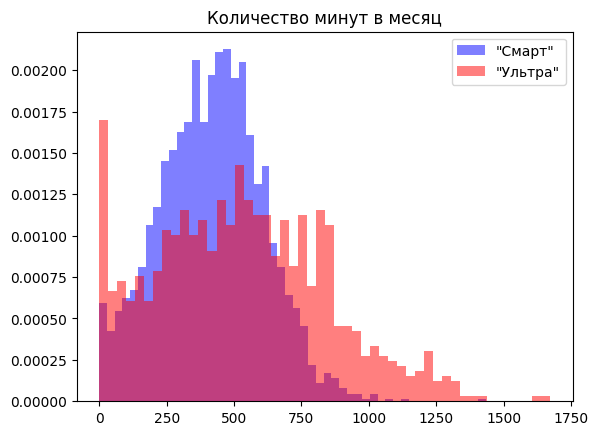

In [26]:
plt.hist(stats[stats['tariff'] == 'smart']['minutes'], alpha=0.5, label='\"Смарт\"', color='blue', density=True, bins=50)
plt.hist(stats[stats['tariff'] == 'ultra']['minutes'], alpha=0.5, label='\"Ультра\"', color='red', density=True, bins=50)
plt.legend()
plt.title('Количество минут в месяц')

Из графика можно предположить, что пользователи тарифа *"Ультра"* дольше разговаривают по телефону. Хотя количество пользователей, которые вообще не пользуется звонками, тоже больше в тарифе *"Ультра"*. В тарифе *"Смарт"* много пользователей, которые расходуют больше предоставленного пакета минут.

Text(0.5, 1.0, 'Количество сообщений в месяц')

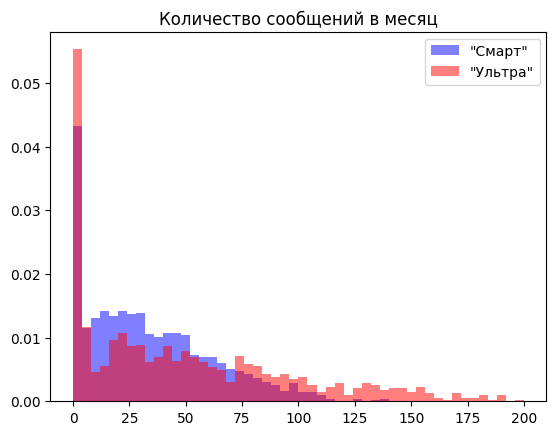

In [27]:
plt.hist(stats[stats['tariff'] == 'smart']['mess_count'], alpha=0.5, label='\"Смарт\"', color='blue', density=True, bins=50, range=(0, 200))
plt.hist(stats[stats['tariff'] == 'ultra']['mess_count'], alpha=0.5, label='\"Ультра\"', color='red', density=True, bins=50, range=(0, 200))
plt.legend()
plt.title('Количество сообщений в месяц')

Тут ситуация аналогичная звонкам. В тарифе *"Ультра"* чаще используют сообщения. Люди чаще вообще не пользуются сообщениями. В тарифе *"Смарт"* видно падение после отметки 50, возможно, пользователи стараются не тратить больше этого значения. Такого скачка нет в минутах, вероятно потому, что их труднее отслеживать. 

Text(0.5, 1.0, 'Объём интернет-трафика в месяц')

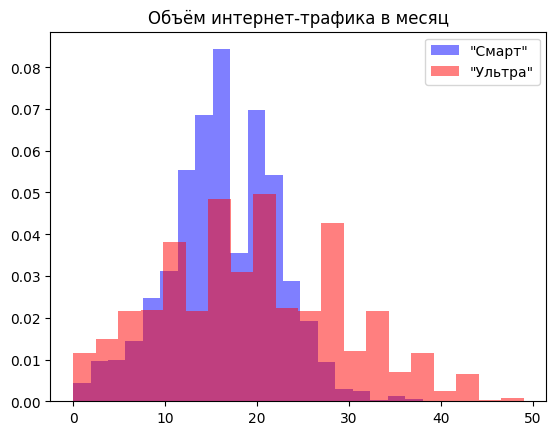

In [28]:
plt.hist(stats[stats['tariff'] == 'smart']['gb'], alpha=0.5, label='\"Смарт\"', color='blue', density=True, bins=20)
plt.hist(stats[stats['tariff'] == 'ultra']['gb'], alpha=0.5, label='\"Ультра\"', color='red', density=True, bins=20)
plt.legend()
plt.title('Объём интернет-трафика в месяц')

Пользователи обоих тарифов имеют падение после отметок 15 и 30, что соответствует предоставляемому объёму интернет-трафика. Однако пользователи тарифа *"Смарт"* часто используют 20-23 Гб интернет-трафика.

Text(0.5, 1.0, 'Количество сообщений в месяц')

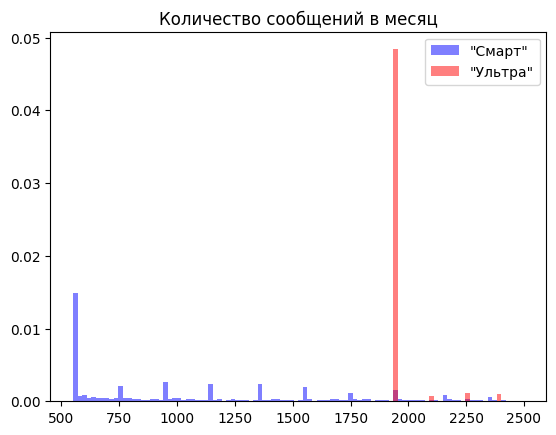

In [29]:
plt.hist(stats[stats['tariff'] == 'smart']['revenue'], alpha=0.5, label='\"Смарт\"', color='blue', density=True, bins=100, range=(550, 2500))
plt.hist(stats[stats['tariff'] == 'ultra']['revenue'], alpha=0.5, label='\"Ультра\"', color='red', density=True, bins=100, range=(550, 2500))
plt.legend()
plt.title('Количество сообщений в месяц')

Пользователи тарифа *"Ультра"* по сравнению с пользователями тарифа *"Смарт"* чаще платят фиксированную стоимость тарифа, не выходя за его пределы, о чём уже говорилось при разраборе метода `.describe()`. Пользователи тарифа *"Смарт"* часто не умещаются в предоставленный пакет услуг, из-за чего чаще платят больше стоимости самого тарифа.

## Проверка гипотез

Гипотезы:
- средняя выручка пользователей тарифов *"Ультра"* и *"Смарт"* различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение *aplha* зададим 0.05.

Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы.

In [30]:
alpha = .05

### Гипотеза: средняя выручка пользователей *"Ультра"* и *"Смарт"* различается.
**H0:** выручка пользователей *"Ультра"* и *"Смарт"* равна.

**H1:** выручка пользоватеей *"Ультра"* и *"Смарт"* не равна.

In [31]:
gip1 = st.ttest_ind(stats[stats['tariff'] == 'ultra']['revenue'], stats[stats['tariff'] == 'smart']['revenue'], equal_var=False)

In [32]:
print('p-значение', gip1.pvalue)

if gip1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 4.2606313931076085e-250
Отвергаем нулевую гипотезу


**Вывод:** Очень малое p-value говорит о том, что вероятность случайного совпадения средних наших выборок ничтожно мала. Отвергаем нулевую гипотезу. Соответственно, сформулированная альтернативная гипотеза не отвергается.

### Гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
**H0:** выручка пользователей из Москвы и из других регионов равна.

**H1:** выручка пользоватеей из Москвы и из других регионов не равна.

In [33]:
gip2 = st.ttest_ind(stats[stats['user_id'].isin(users[users['city'] == 'Москва']['user_id'])]['revenue'], 
                    stats[stats['user_id'].isin(users[users['city'] != 'Москва']['user_id'])]['revenue'], equal_var=False)

In [34]:
print('p-значение', gip2.pvalue)

if gip2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Значение p-value получилось равным 0.53. Получается, что с вероятностью более 50% отличие среднех наших выборок случайны и мы не можем отвергнуть нулевую гипотезу.  Соответственно, мы отвергаем альтернативную гипотезу.

## Общий вывод

Оказалось, действительно, средняя прибыль в друх тарифах отличается, более того, мы заметили, что средние израсходованные количества звонков, сообщений и объёма интернет-трафика не сильно отличаются между тарифами, тогда как базовая стоимость тарифов отличается почти в 4 раза.

**Прибыль от тарифа** ***"Ультра"*** **выше, чем прибыль от тарифа** ***"Смарт"*.** Однако итоговая стоимость услуг даже с переплатами остаётся меньше у тарифа *"Смарт"*, что делает его более выгодным для пользователя.

Доход из Москвы и из регионов сильно не отличается, каждая категория приносит деньги. 

Стоит подумать надо оптимизацией тарифов. Для пользователей тарифа *"Смарт"* не редкость выйти за включённый пакет услуг, тогда как у пользователей тарифа *"Ультра"* часто есть неизрасходованный пакет услуг (сообщений так вообще часто 80%).